In [3]:
import cvxpy as cvx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [9]:

# Set path of your working directory - change yours here!
dir = '/Users/nathanielramos/Documents/RMI/CEE 266F/266G'

# Import data
# All units in MCM
data = pd.read_csv(dir + '/net_inflow.csv', header=None, names=['Year', 'Inflow'])
data = data[data['Year']>=2000]
pipeline = np.loadtxt(dir + '/pipeline_availability.csv', delimiter=',')
demand = np.loadtxt(dir + '/demand.csv', delimiter=',')
data['Pipeline'] = pipeline[:,1]
data['Demand'] = demand[:,1]
del demand, pipeline
data = data.set_index('Year')

# Parameters
desalCapacity = 150 # [MCM]
K = 1812 # reservoir capacity [MCM]
K0 = 600 # initial storage capacity [MCM]
minK = 580 # minimum storage level [MCM]
KT = K0 # final storage capacity [MCM]
pipelineCost = 0.28 * 10**6 # $ per MCM
desalCost = 0.45 * 10**6 # $ per MCM

In [10]:

# Number of time periods
T = 2015 - 2000 + 1
years = np.arange(2000, 2016)

# Create a vector S of storage decision variables for each time period
S = cvx.Variable(T)

# Create a vector R of releases each time period
R = cvx.Variable(T)

# Create a vector P of pipeline water imports in each t
P = cvx.Variable(T)

# Create a vector D of desal water imports in each t
D = cvx.Variable(T)

#slack & surplus variables
x_1_slack = cvx.Variable(T)
x_2_surplus = cvx.Variable(T)
x_3_surplus = cvx.Variable(T)
x_4_slack = cvx.Variable(T)
x_5_slack = cvx.Variable(T)


# Create  list of constraints
constraints = []

# Add initial storage constraint
constraints += [S[0] == K0]
#adding logical constraints?

# Loop over time range and add constraints that apply in all time periods
for t in range(T):

    # Add water balance constraints
    if t < T-1:
        constraints += [
            S[t + 1] == S[t] - R[t] + data['Inflow'].iloc[t] + P[t] + D[t]
        ]
    else:
        # last time period
        constraints += [
            S[t] - R[t] + data['Inflow'].iloc[t] + P[t] + D[t] == KT
        ]

    # Add storage capacity constraints
    constraints += [
        S[t] + x_1_slack[t] == K,  # Storage can't be above capacity
        S[t] + x_2_surplus[t] == minK # Storage can't go below minimum threshold
    ]

    # Add reliability constraints
    constraints += [
        R[t] + x_3_surplus[t] == data['Demand'].iloc[t]
    ]

    # Add pipeline and desal availability constraints
    constraints += [
        P[t] + x_4_slack[t] == data['Pipeline'].iloc[t],
        D[t] + x_5_slack[t] == desalCapacity
    ]

    # Add non-negativity constraints
    constraints += [
        S[t] >= 0, R[t] >= 0, P[t] >= 0, D[t] >= 0, x_1_slack[t] >= 0,
        x_2_surplus[t] <= 0, x_3_surplus[t] <= 0, x_4_slack[t] >= 0, x_5_slack[t] >= 0
    ]
# Create objective function
objective = cvx.Minimize(cvx.sum(P) * pipelineCost +
                         cvx.sum(D) * desalCost)
# using cvx.sum bc p is weird class; it's a decision variable class

In [11]:
prob = cvx.Problem(objective, constraints)
prob.solve()
print("Solution status: " + prob.status)
print("Optimal objective value: {}".format(prob.objective.value))
print("Optimal values of storage DVs: {}".format(S.value))
print("Optimal values of release DVs: {}".format(R.value))
print("Optimal values of pipeline DVs: {}".format(P.value))
print("Optimal values of desal DVs: {}".format(D.value))
print("Optimal values of x_1_slack DVs: {}".format(x_1_slack.value))
print("Optimal values of x_2_surplus DVs: {}".format(x_2_surplus.value))
print("Optimal values of x_3_surplus DVs: {}".format(x_3_surplus.value))
print("Optimal values of x_4_slack DVs: {}".format(x_4_slack.value))
print("Optimal values of x_5_slack DVs: {}".format(x_5_slack.value))


# Don't continue with analysis of results unless optimal solution found
if(prob.status != 'optimal'):
    sys.exit()

Solution status: optimal
Optimal objective value: 633469999.9225835
Optimal values of storage DVs: [ 600.          827.89112189  909.45942414  801.88382643 1014.73549094
 1236.6275869  1227.82932517  861.30721867  796.12534607  597.57699233
  580.00000001  747.2879833  1017.82827528 1286.00679235 1238.7863002
 1194.36809574]
Optimal values of release DVs: [517.99999998 547.99999998 569.99999998 529.99999998 529.99999998
 556.99999998 607.99999998 559.99999998 578.99999998 560.99999998
 518.         501.         495.         551.         549.
 636.        ]
Optimal values of pipeline DVs: [172.         189.         124.         218.99999999 229.
 145.          65.00000001 107.00000001  79.00000001 163.99999997
 126.28798327 137.54029198 105.17851706  87.77950784  83.58179553
   5.63190426]
Optimal values of desal DVs: [1.38911219e+01 1.45683022e+01 1.44244023e+01 1.48516645e+01
 1.48920959e+01 1.42017383e+01 1.34778935e+01 1.38181274e+01
 1.44516462e+01 1.04230077e+01 4.54810719e-09 5.4

/Users/nathanielramos/opt/anaconda3/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


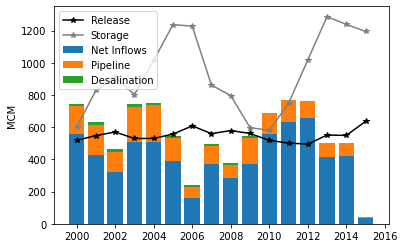

In [12]:

# Calculate water balance
deltaS = np.diff(np.append(S.value, KT))
supply = data['Inflow'] + P.value + D.value
balance = deltaS - supply + R.value

# Verify that water balance is zero
if np.abs(sum(balance)) > 0.1:
    raise Exception("Water balance does not sum to zero")

# Plot water supply and demand
plt.figure()
plt.bar(data.index, data['Inflow'], label='Net Inflows')
plt.bar(data.index, P.value, label='Pipeline', bottom=data['Inflow'])
plt.bar(data.index, D.value, label='Desalination', bottom=data['Inflow'] + P.value)
plt.plot(data.index, R.value, 'k*-', label='Release')
plt.plot(data.index, S.value, '*-', c='gray', label='Storage')
plt.legend()
plt.ylabel('MCM')
plt.show()